In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crowd-counting/images.npy
/kaggle/input/crowd-counting/labels.npy
/kaggle/input/crowd-counting/labels.csv
/kaggle/input/crowd-counting/frames/frames/seq_000094.jpg
/kaggle/input/crowd-counting/frames/frames/seq_001420.jpg
/kaggle/input/crowd-counting/frames/frames/seq_001778.jpg
/kaggle/input/crowd-counting/frames/frames/seq_001251.jpg
/kaggle/input/crowd-counting/frames/frames/seq_001273.jpg
/kaggle/input/crowd-counting/frames/frames/seq_000295.jpg
/kaggle/input/crowd-counting/frames/frames/seq_001958.jpg
/kaggle/input/crowd-counting/frames/frames/seq_001230.jpg
/kaggle/input/crowd-counting/frames/frames/seq_001086.jpg
/kaggle/input/crowd-counting/frames/frames/seq_001595.jpg
/kaggle/input/crowd-counting/frames/frames/seq_000146.jpg
/kaggle/input/crowd-counting/frames/frames/seq_000477.jpg
/kaggle/input/crowd-counting/frames/frames/seq_000889.jpg
/kaggle/input/crowd-counting/frames/frames/seq_001591.jpg
/kaggle/input/crowd-counting/frames/frames/seq_000115.jpg
/kaggle/in

In [2]:
import os
import shutil
import cv2
import zipfile
import itertools
import warnings
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K
warnings.filterwarnings("ignore")
print("All dependencies are imported.")

2025-09-03 13:21:50.987947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756905711.175026      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756905711.229092      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All dependencies are imported.


In [3]:
print("Importing the Datasets:")
labels_df=pd.read_csv("/kaggle/input/crowd-counting/labels.csv")
display(labels_df)

Importing the Datasets:


id  count
0        1     35
1        2     41
2        3     41
3        4     44
4        5     41
...    ...    ...
1995  1996     27
1996  1997     27
1997  1998     25
1998  1999     26
1999  2000     26

[2000 rows x 2 columns]

In [4]:
print("Map each id to its appropriate file name:")
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
labels_df.drop("id", axis=1,inplace=True)
display(labels_df)

Map each id to its appropriate file name:


count      image_name
0        35  seq_000001.jpg
1        41  seq_000002.jpg
2        41  seq_000003.jpg
3        44  seq_000004.jpg
4        41  seq_000005.jpg
...     ...             ...
1995     27  seq_001996.jpg
1996     27  seq_001997.jpg
1997     25  seq_001998.jpg
1998     26  seq_001999.jpg
1999     26  seq_002000.jpg

[2000 rows x 2 columns]

In [5]:
img_size=(240,320)
batch_size=16
print(f"Declaring the image size to be {img_size} and batch size to be {batch_size}.")


Declaring the image size to be (240, 320) and batch size to be 16.


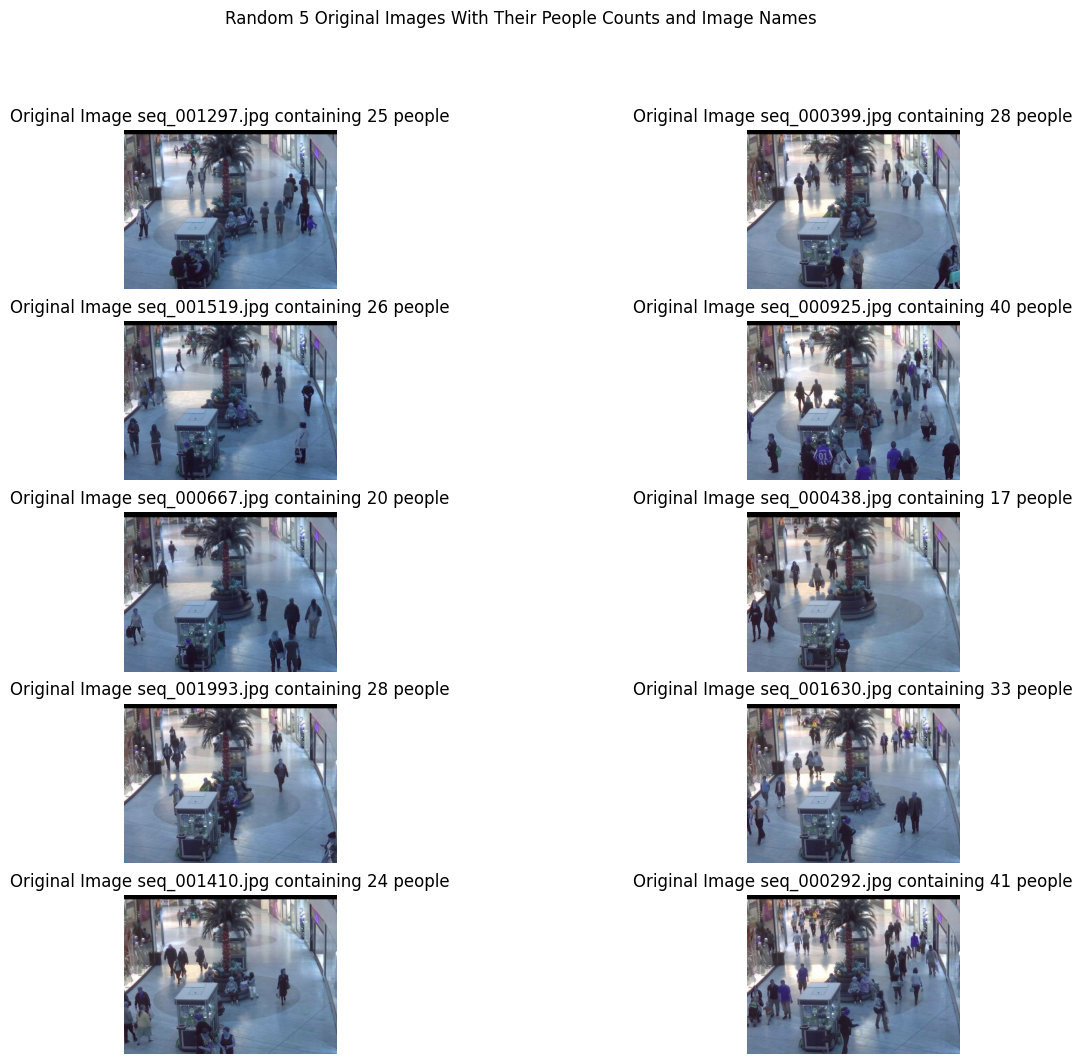

In [6]:
num_img_display = 10
fig, axes = plt.subplots(5,2, figsize=(16, 12))

for i in range(num_img_display):
    rand_idx=np.random.randint(0,len(labels_df))
    img_label = labels_df.loc[rand_idx, "count"]
    ax_original = axes[i//2,i%2]
    original_image_name = labels_df.loc[rand_idx, "image_name"]
    #print(original_image_name)
    original_image_path="/kaggle/input/crowd-counting/frames/frames/"+original_image_name
    #print(original_image_path)
    original_image=cv2.imread(original_image_path)
    ax_original.imshow(original_image)
    ax_original.axis("off")
    ax_original.set_title(f"Original Image {original_image_name} containing {img_label} people")

plt.suptitle("Random 5 Original Images With Their People Counts and Image Names")
plt.subplots_adjust(wspace=0.01)
plt.show()

In [7]:
print("Labels dataframe description:")
display(labels_df.describe())


Labels dataframe description:


count
count  2000.000000
mean     31.157500
std       6.945417
min      13.000000
25%      26.000000
50%      31.000000
75%      36.000000
max      53.000000

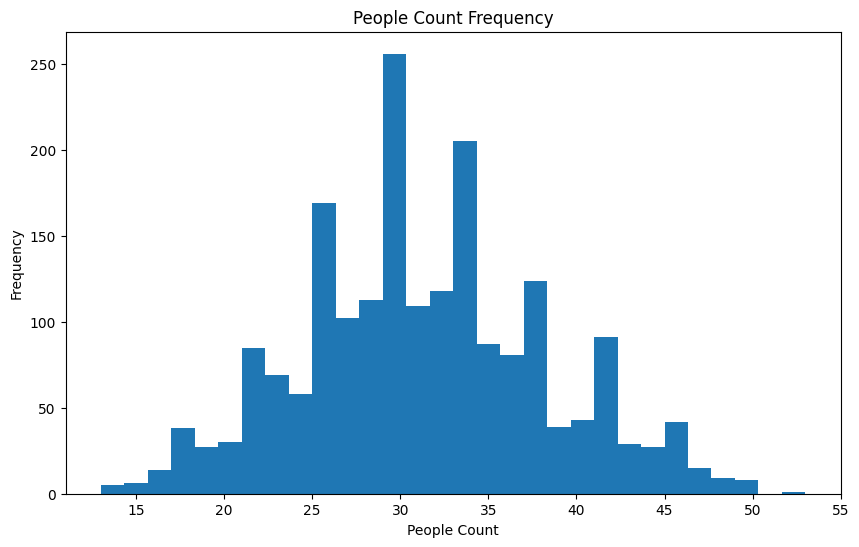

In [8]:
fig=plt.figure(figsize=(10,6))
labels_df['count'].hist(bins=30)
plt.xlabel("People Count")
plt.ylabel("Frequency")
plt.title("People Count Frequency")
plt.grid(False)
plt.show()


In [9]:
print("Data Augmentation Generator:")
img_aug=ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest')
print(img_aug)

Data Augmentation Generator:


In [10]:
shuffled_df = labels_df.sample(frac=1).reset_index(drop=True)
print("Shuffling the labels DF:")
display(shuffled_df)


Shuffling the labels DF:


count      image_name
0        36  seq_000368.jpg
1        43  seq_000992.jpg
2        32  seq_001218.jpg
3        43  seq_001619.jpg
4        16  seq_000476.jpg
...     ...             ...
1995     35  seq_001455.jpg
1996     35  seq_000131.jpg
1997     42  seq_000906.jpg
1998     32  seq_000949.jpg
1999     29  seq_000154.jpg

[2000 rows x 2 columns]

In [11]:
print("Creating a training set:")
train_set=img_aug.flow_from_dataframe(
    dataframe=shuffled_df,
    directory='/kaggle/input/crowd-counting/frames/frames',
    x_col="image_name",
    y_col="count",
    target_size=img_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode="raw",
    subset="training",
    )
print(np.array(train_set.filenames)[:10])

Creating a training set:
Found 1600 validated image filenames.
['seq_001060.jpg' 'seq_001735.jpg' 'seq_001579.jpg' 'seq_001144.jpg'
 'seq_001895.jpg' 'seq_000506.jpg' 'seq_001118.jpg' 'seq_001970.jpg'
 'seq_001679.jpg' 'seq_001138.jpg']


In [12]:
print("Creating a validation set:")
validation_set=img_aug.flow_from_dataframe(
    dataframe=shuffled_df,
    directory='/kaggle/input/crowd-counting/frames/frames',
    x_col="image_name",
    y_col="count",
    target_size=img_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode="raw",
    subset="validation",
    )
print(np.array(validation_set.filenames)[:10])

Creating a validation set:
Found 400 validated image filenames.
['seq_000368.jpg' 'seq_000992.jpg' 'seq_001218.jpg' 'seq_001619.jpg'
 'seq_000476.jpg' 'seq_001867.jpg' 'seq_000482.jpg' 'seq_001835.jpg'
 'seq_000422.jpg' 'seq_001370.jpg']


In [13]:
model_path="Crowd_Counting_Model1.h5"
checkpoint=ModelCheckpoint(
    filepath=model_path,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True,
    verbose=1
)
print("Model Checkpoint Created:")
print(checkpoint)
print()
print("Learning Rate Reduction:")
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  
    patience=3,  
    verbose=1, 
    factor=0.2,  
    min_lr=0.000001
)
print(learning_rate_reduction)

Model Checkpoint Created:

Learning Rate Reduction:


In [14]:
vgg16=VGG16(include_top=False,weights="imagenet",input_shape=(240,320,3),pooling="avg")
x = vgg16.output  
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='linear')(x)
model1=Model(inputs=vgg16.input, outputs=predictions)
k = -7
for layer in model1.layers[:k]:
    layer.trainable = False
print('Trainable layers:')
for layer in model1.layers[k:]:
    print(layer.name)
    layer.trainable = True
print()
display(model1.summary())

I0000 00:00:1756905780.603837      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Trainable layers:
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d
dense
dense_1



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 320, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 320, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 160, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 160, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 80, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 80, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 80, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 40, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 40, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 20, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 10, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 7,605,761 (29.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

None

In [15]:
optimizer = Adam(learning_rate=0.001)
model1.compile(
    optimizer=optimizer, 
    loss="mean_squared_error", 
    metrics=['mean_absolute_error', 'mean_squared_error']
)
history = model1.fit(
    train_set,
    epochs=50, 
    validation_data=validation_set,
    verbose=2, 
    callbacks=[checkpoint, learning_rate_reduction],
)
print('\nModel Training Finished.')

Epoch 1/50


I0000 00:00:1756905790.814737      98 service.cc:148] XLA service 0x7eb988010590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756905790.815498      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756905791.269057      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-03 13:23:15.942068: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[16,128,120,160]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,120,160]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-09-03


Epoch 1: val_mean_squared_error improved from inf to 22.88037, saving model to Crowd_Counting_Model1.h5
100/100 - 57s - 568ms/step - loss: 80.8402 - mean_absolute_error: 6.5351 - mean_squared_error: 80.8402 - val_loss: 22.8804 - val_mean_absolute_error: 3.8506 - val_mean_squared_error: 22.8804 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_mean_squared_error improved from 22.88037 to 13.11185, saving model to Crowd_Counting_Model1.h5
100/100 - 34s - 337ms/step - loss: 17.9704 - mean_absolute_error: 3.4017 - mean_squared_error: 17.9704 - val_loss: 13.1118 - val_mean_absolute_error: 2.9163 - val_mean_squared_error: 13.1118 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_mean_squared_error improved from 13.11185 to 9.48930, saving model to Crowd_Counting_Model1.h5
100/100 - 34s - 343ms/step - loss: 12.6029 - mean_absolute_error: 2.7674 - mean_squared_error: 12.6029 - val_loss: 9.4893 - val_mean_absolute_error: 2.4930 - val_mean_squared_error: 9.4893 - learning_rate: 0.0010
Epoch 4/50


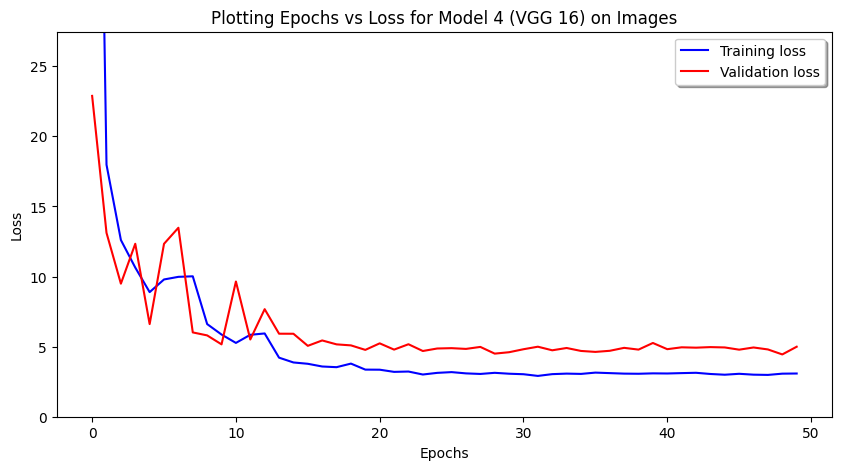

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history.history['val_loss'])*1.2, bottom=0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
legend = ax.legend(loc='best', shadow=True)
plt.title("Plotting Epochs vs Loss for Model 4 (VGG 16) on Images")
plt.show()

In [17]:
print("Evaluating the retrieved model:")
MSE, MAE=model1.evaluate(validation_set, batch_size=batch_size)[:-1]
print("Mean Squared Error:")
print(round(MSE,2))
print("Mean Absolute Error:")
print(round(MAE,2))


Evaluating the retrieved model:
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - loss: 4.5151 - mean_absolute_error: 1.7038 - mean_squared_error: 4.5151
Mean Squared Error:
4.76
Mean Absolute Error:
1.73


In [18]:
model_paths=["/kaggle/working/Crowd_Counting_Model1.h5","/kaggle/input/crowd-count-vgg16/Crowd_Counting_Model1.h5"]
model_path=None
for path in model_paths:
    if os.path.exists(path):
        model_path=path
print(f"Fetching the model from path: {model_path}.")

Fetching the model from path: /kaggle/working/Crowd_Counting_Model1.h5.


In [19]:
print("Retrieving the model and ensuring its performance:")
model1=load_model(model_path)
MSE, MAE=model1.evaluate(validation_set, batch_size=batch_size)[:-1]
print("Mean Squared Error:")
print(round(MSE,2))
print("Mean Absolute Error:")
print(round(MAE,2))


Retrieving the model and ensuring its performance:
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - loss: 4.4691 - mean_absolute_error: 1.6514 - mean_squared_error: 4.4691
Mean Squared Error:
4.58
Mean Absolute Error:
1.69


In [20]:
validation_set.reset()
all_labels = []
all_pred = []
for i in range(len(validation_set)):
    x = next(validation_set)
    pred_i = np.round(model1.predict(x[0])[:,0]).astype(int)
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
y_valid = np.concatenate(all_labels)
y_pred= np.concatenate(all_pred)
print("All prediction done.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
All prediction done.


In [21]:
print("Final Model Evaluation:")
F_MSE = mean_squared_error(y_valid, y_pred)
F_MAE =  mean_absolute_error(y_valid, y_pred)
R2 = r2_score(y_valid, y_pred)
print(f'Final Mean Squared Error: {F_MSE:.2f}.')
print(f'Final Mean Absolute Error: {F_MAE:.2f}.')
print(f'R Squared Score: {R2:.2f}.')

Final Model Evaluation:
Final Mean Squared Error: 4.88.
Final Mean Absolute Error: 1.71.
R Squared Score: 0.90.


In [22]:
print("Getting the file names from the validation set & displaying 1st 10 filenames:")
validation_filenames=np.array(validation_set.filenames)
print(validation_filenames[:10])


Getting the file names from the validation set & displaying 1st 10 filenames:
['seq_000368.jpg' 'seq_000992.jpg' 'seq_001218.jpg' 'seq_001619.jpg'
 'seq_000476.jpg' 'seq_001867.jpg' 'seq_000482.jpg' 'seq_001835.jpg'
 'seq_000422.jpg' 'seq_001370.jpg']


In [23]:
pred_df = pd.DataFrame({"Image Name": validation_filenames,'True values': y_valid, 'Predicted values': y_pred})
print("Predictions Dataframe:")
display(pred_df)

Predictions Dataframe:


Image Name  True values  Predicted values
0    seq_000368.jpg           36                34
1    seq_000992.jpg           43                42
2    seq_001218.jpg           32                31
3    seq_001619.jpg           43                44
4    seq_000476.jpg           16                18
..              ...          ...               ...
395  seq_000951.jpg           32                34
396  seq_001713.jpg           43                40
397  seq_000523.jpg           22                21
398  seq_000962.jpg           31                33
399  seq_001520.jpg           27                28

[400 rows x 3 columns]

In [24]:
def get_risk_zone(count):
    if count < 10:
        return "Low Risk"
    elif count < 30:
        return "Medium Risk"
    elif count < 60:
        return "Moderate Risk"
    else:
        return "High Risk"

In [25]:
print("Enter the image path to predict:")
img_path="/kaggle/input/crowd-counting/frames/frames/seq_001190.jpg"
print(f"Image filepath: {img_path}")

Enter the image path to predict:
Image filepath: /kaggle/input/crowd-counting/frames/frames/seq_001190.jpg


In [26]:
image_data = tf.io.read_file(img_path)
image_decoded = tf.image.decode_jpeg(image_data)
image_resized = tf.image.resize(image_decoded,img_size)
print(f"Image resized to {img_size}:")
display(image_resized)
print()
image_normalized = tf.cast(image_resized, dtype=tf.float32) / 255.0
image_batch = tf.expand_dims(image_normalized, axis=0)
print("Tensorflow vector of singular Test image:")
display(image_batch)

Image resized to (240, 320):


<tf.Tensor: shape=(240, 320, 3), dtype=float32, numpy=
array([[[  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ]],

       [[  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ]],

       [[  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ]],

       ...,

       [[146.75, 125.  ,  74.5 ],
        [144.5 , 121.  ,  83.25],
        [146.5 , 120.  ,  97.  ],
        ...,
        [190.75, 151.75, 110.75],
        [198.75, 160.25, 116.25],
        [201.75, 163.75, 117.25]],

       [[150.75, 129.75,  75.25],
        [146.25, 122.7


Tensorflow vector of singular Test image:


<tf.Tensor: shape=(1, 240, 320, 3), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.5754902 , 0.49019608, 

In [27]:
print("Final prediction:")
prediction = model1.predict(image_batch)[0,0]
predicted_count=int(np.round(prediction))
print(predicted_count)

Final prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
41


Risk Zone: Moderate Risk


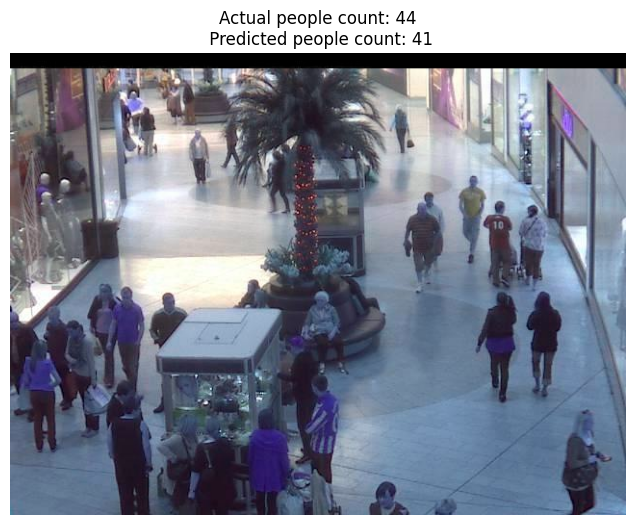

In [28]:
fig = plt.figure(figsize=(10, 6))
img_name=img_path.split("/")[-1]
img = cv2.imread(img_path)
img=img.astype(np.uint8)
plt.imshow(img)
actual_count = labels_df[labels_df["image_name"] == img_name]["count"].values[0]
plt.title(f"Actual people count: {actual_count}\n Predicted people count: {predicted_count}")

risk_zone = get_risk_zone(actual_count)
print(f"Risk Zone: {risk_zone}")

plt.axis("off")
plt.show()

In [29]:
print("Enter the image path to predict:")
img_path="/kaggle/input/crowd-counting/frames/frames/seq_001388.jpg"
print(f"Image filepath: {img_path}")

Enter the image path to predict:
Image filepath: /kaggle/input/crowd-counting/frames/frames/seq_001388.jpg


In [30]:
image_data = tf.io.read_file(img_path)
image_decoded = tf.image.decode_jpeg(image_data)
image_resized = tf.image.resize(image_decoded,img_size)
print(f"Image resized to {img_size}:")
display(image_resized)
print()
image_normalized = tf.cast(image_resized, dtype=tf.float32) / 255.0
image_batch = tf.expand_dims(image_normalized, axis=0)
print("Tensorflow vector of singular Test image:")
display(image_batch)


Image resized to (240, 320):


<tf.Tensor: shape=(240, 320, 3), dtype=float32, numpy=
array([[[  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ]],

       [[  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ]],

       [[  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ]],

       ...,

       [[148.25, 127.75,  79.25],
        [147.75, 126.25,  84.25],
        [147.5 , 124.5 ,  92.  ],
        ...,
        [192.75, 155.5 , 113.75],
        [204.25, 167.25, 122.75],
        [207.5 , 171.25, 124.  ]],

       [[152.25, 132.25,  80.75],
        [149.25, 128.2


Tensorflow vector of singular Test image:


<tf.Tensor: shape=(1, 240, 320, 3), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.58137256, 0.5009804 , 

In [31]:
print("Final prediction:")
prediction = model1.predict(image_batch)[0,0]
predicted_count=int(np.round(prediction))
print(predicted_count)

Final prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
26


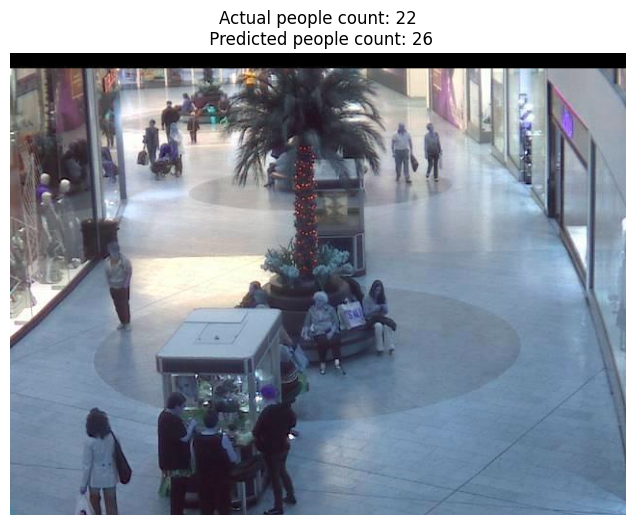

In [32]:
fig = plt.figure(figsize=(10, 6))
img_name=img_path.split("/")[-1]
img = cv2.imread(img_path)
img=img.astype(np.uint8)
plt.imshow(img)
actual_count = labels_df[labels_df["image_name"] == img_name]["count"].values[0]
plt.title(f"Actual people count: {actual_count}\n Predicted people count: {predicted_count}")
plt.axis("off")
plt.show()


In [33]:
print("Enter the image path to predict:")
img_path1="/kaggle/input/crowd-test-images/Crowd1.jpg"
print(f"Image filepath: {img_path1}")

Enter the image path to predict:
Image filepath: /kaggle/input/crowd-test-images/Crowd1.jpg


In [34]:
image_data1 = tf.io.read_file(img_path1)
image_decoded1 = tf.image.decode_jpeg(image_data1)
image_resized1 = tf.image.resize(image_decoded1,img_size)
print(f"Image resized to {img_size}:")
display(image_resized1)
print()
image_normalized1 = tf.cast(image_resized1, dtype=tf.float32) / 255.0
image_batch1 = tf.expand_dims(image_normalized1, axis=0)
print("Tensorflow vector of singular Test image:")
display(image_batch1)


Image resized to (240, 320):


<tf.Tensor: shape=(240, 320, 3), dtype=float32, numpy=
array([[[182.2998  , 184.2998  , 183.2998  ],
        [183.50684 , 185.50684 , 184.50684 ],
        [180.3208  , 182.3208  , 181.3208  ],
        ...,
        [ 74.      ,  67.265625,  64.84375 ],
        [ 76.9375  ,  68.9375  ,  66.9375  ],
        [ 82.71875 ,  74.71875 ,  72.71875 ]],

       [[166.14111 , 168.14111 , 167.14111 ],
        [177.32959 , 179.32959 , 178.32959 ],
        [180.85547 , 182.85547 , 181.85547 ],
        ...,
        [ 72.61426 ,  66.69287 ,  64.      ],
        [ 74.6875  ,  68.09375 ,  65.625   ],
        [ 79.3833  ,  72.78955 ,  70.3208  ]],

       [[109.05469 , 111.05469 , 110.05469 ],
        [149.0957  , 151.0957  , 150.0957  ],
        [173.70215 , 175.70215 , 174.70215 ],
        ...,
        [ 72.45166 ,  67.78125 ,  64.78125 ],
        [ 73.447754,  68.447754,  65.447754],
        [ 76.33154 ,  71.734375,  68.734375]],

       ...,

       [[154.9082  , 158.46387 , 161.90137 ],
        [145.


Tensorflow vector of singular Test image:


<tf.Tensor: shape=(1, 240, 320, 3), dtype=float32, numpy=
array([[[[0.7149012 , 0.72274435, 0.7188228 ],
         [0.71963465, 0.7274778 , 0.7235562 ],
         [0.7071404 , 0.7149835 , 0.71106195],
         ...,
         [0.2901961 , 0.26378676, 0.2542892 ],
         [0.30171567, 0.27034312, 0.2625    ],
         [0.32438725, 0.2930147 , 0.28517157]],

        [[0.6515338 , 0.6593769 , 0.65545535],
         [0.69541013, 0.70325327, 0.6993317 ],
         [0.70923716, 0.7170803 , 0.7131587 ],
         ...,
         [0.2847618 , 0.26154068, 0.2509804 ],
         [0.29289216, 0.26703432, 0.25735295],
         [0.31130707, 0.2854492 , 0.27576783]],

        [[0.42766544, 0.43550858, 0.431587  ],
         [0.584689  , 0.59253216, 0.5886106 ],
         [0.6811849 , 0.689028  , 0.68510646],
         ...,
         [0.28412417, 0.26580882, 0.25404412],
         [0.28803042, 0.26842257, 0.25665787],
         [0.29933938, 0.28131127, 0.26954657]],

        ...,

        [[0.60748315, 0.62142694, 

In [35]:
print("Final prediction:")
prediction1 = model1.predict(image_batch1)[0,0]
predicted_count1=int(np.round(prediction1))
print(predicted_count1)

risk_zone = get_risk_zone(actual_count)
print(f"Risk Zone: {risk_zone}")


Final prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
53
Risk Zone: Medium Risk


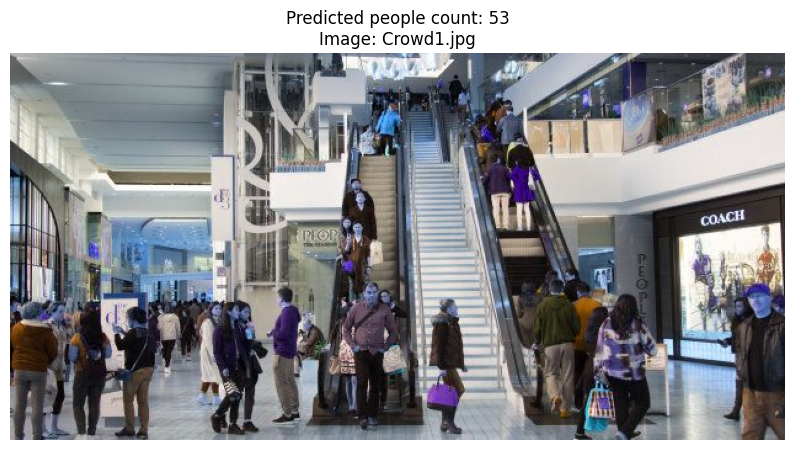

In [36]:
fig = plt.figure(figsize=(10, 6))
img_name1=img_path1.split("/")[-1]
img1 = cv2.imread(img_path1)
img1 = img1.astype(np.uint8)
plt.imshow(img1)
plt.title(f"Predicted people count: {predicted_count1}\nImage: {img_name1}")
plt.axis("off")
plt.show()


In [37]:
print("Enter the image path to predict:")
img_path2="/kaggle/input/crowd-test-images/Crowd2.jpg"
print(f"Image filepath: {img_path2}")

Enter the image path to predict:
Image filepath: /kaggle/input/crowd-test-images/Crowd2.jpg


In [38]:
image_data2 = tf.io.read_file(img_path2)
image_decoded2 = tf.image.decode_jpeg(image_data2)
image_resized2 = tf.image.resize(image_decoded2,img_size)
print(f"Image resized to {img_size}:")
display(image_resized2)
print()
image_normalized2 = tf.cast(image_resized2, dtype=tf.float32) / 255.0
image_batch2 = tf.expand_dims(image_normalized2, axis=0)
print("Tensorflow vector of singular Test image:")
display(image_batch2)

Image resized to (240, 320):


<tf.Tensor: shape=(240, 320, 3), dtype=float32, numpy=
array([[[239.98311 , 238.98311 , 233.98311 ],
        [237.22604 , 236.22604 , 232.22604 ],
        [241.04688 , 240.04688 , 238.04688 ],
        ...,
        [190.27246 , 111.81299 ,  96.208824],
        [166.92056 , 118.85794 ,  94.23504 ],
        [119.53358 ,  98.26436 ,  98.20814 ]],

       [[240.80313 , 239.80313 , 234.80313 ],
        [239.02284 , 238.02284 , 234.02284 ],
        [241.79346 , 240.79346 , 238.79346 ],
        ...,
        [158.24658 ,  76.57129 ,  60.658203],
        [163.75691 ,  95.03695 ,  70.67866 ],
        [162.87144 ,  99.860275,  86.070625]],

       [[241.99063 , 240.99063 , 235.99063 ],
        [240.98988 , 239.98988 , 235.98988 ],
        [242.94319 , 241.94319 , 239.94319 ],
        ...,
        [ 90.03952 ,  30.442524,  22.332176],
        [159.96483 ,  90.02753 ,  78.07981 ],
        [146.03925 ,  82.96948 ,  66.0079  ]],

       ...,

       [[239.01283 , 239.97534 , 233.98471 ],
        [237.


Tensorflow vector of singular Test image:


<tf.Tensor: shape=(1, 240, 320, 3), dtype=float32, numpy=
array([[[[0.94111025, 0.9371887 , 0.91758084],
         [0.9302982 , 0.92637664, 0.91069037],
         [0.94528186, 0.9413603 , 0.93351716],
         ...,
         [0.7461665 , 0.4384823 , 0.3772895 ],
         [0.6545904 , 0.46610957, 0.36954919],
         [0.46875912, 0.38535044, 0.38512996]],

        [[0.944326  , 0.9404044 , 0.9207966 ],
         [0.9373445 , 0.9334229 , 0.91773665],
         [0.94820964, 0.9442881 , 0.93644494],
         ...,
         [0.62057483, 0.30027956, 0.23787531],
         [0.64218396, 0.37269393, 0.2771712 ],
         [0.6387116 , 0.39160892, 0.33753186]],

        [[0.9489829 , 0.9450613 , 0.9254535 ],
         [0.94505835, 0.9411368 , 0.9254505 ],
         [0.9527184 , 0.9487968 , 0.9409537 ],
         ...,
         [0.35309616, 0.11938245, 0.08757716],
         [0.6273131 , 0.35304913, 0.30619535],
         [0.57270294, 0.32537052, 0.2588545 ]],

        ...,

        [[0.9373052 , 0.9410798 , 

In [39]:
print("Final prediction:")
prediction2 = model1.predict(image_batch2)[0,0]
predicted_count2=int(np.round(prediction2))
print(predicted_count2)
risk_zone = get_risk_zone(actual_count)
print(f"Risk Zone: {risk_zone}")


Final prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
60
Risk Zone: Medium Risk


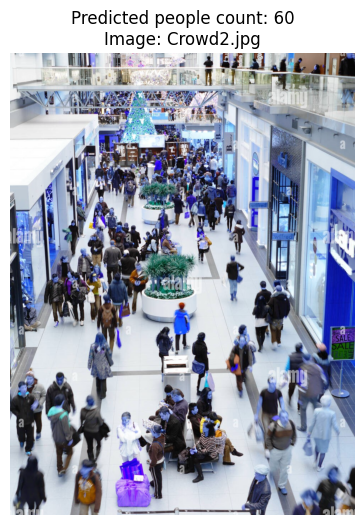

In [40]:
fig = plt.figure(figsize=(10, 6))
img_name2=img_path2.split("/")[-1]
img2 = cv2.imread(img_path2)
img2 = img2.astype(np.uint8)
plt.imshow(img2)
plt.title(f"Predicted people count: {predicted_count2}\nImage: {img_name2}")
plt.axis("off")
plt.show()

In [41]:
print("Enter the image path to predict:")
img_path3="/kaggle/input/crowd-test-images/Crowd3.jpg"
print(f"Image filepath: {img_path3}")

Enter the image path to predict:
Image filepath: /kaggle/input/crowd-test-images/Crowd3.jpg


In [42]:
image_data3 = tf.io.read_file(img_path3)
image_decoded3 = tf.image.decode_jpeg(image_data3)
image_resized3 = tf.image.resize(image_decoded3,img_size)
print(f"Image resized to {img_size}:")
display(image_resized3)
print()
image_normalized3 = tf.cast(image_resized3, dtype=tf.float32) / 255.0
image_batch3 = tf.expand_dims(image_normalized3, axis=0)
print("Tensorflow vector of singular Test image:")
display(image_batch3)

Image resized to (240, 320):


<tf.Tensor: shape=(240, 320, 3), dtype=float32, numpy=
array([[[5.49616776e+01, 6.29616814e+01, 6.59616852e+01],
        [5.58618851e+01, 6.08618851e+01, 6.68618851e+01],
        [3.90101547e+01, 4.11195297e+01, 5.04164047e+01],
        ...,
        [1.09468262e+02, 1.31468262e+02, 1.44468262e+02],
        [1.10134689e+02, 1.29134689e+02, 1.43134689e+02],
        [1.10000000e+02, 1.29000000e+02, 1.43000000e+02]],

       [[4.89591026e+01, 5.74966049e+01, 6.02278557e+01],
        [1.38660934e+02, 1.44198441e+02, 1.50198441e+02],
        [2.36079082e+01, 2.73110332e+01, 3.63110313e+01],
        ...,
        [1.09296875e+02, 1.31296875e+02, 1.44296875e+02],
        [1.09000000e+02, 1.31000000e+02, 1.43462494e+02],
        [1.08312134e+02, 1.30312134e+02, 1.42774628e+02]],

       [[1.11830666e+02, 1.22611916e+02, 1.24611916e+02],
        [8.32774353e+01, 9.18399353e+01, 9.70586853e+01],
        [1.45727539e+01, 1.98481445e+01, 2.82988281e+01],
        ...,
        [1.10231934e+02, 1.32231


Tensorflow vector of singular Test image:


<tf.Tensor: shape=(1, 240, 320, 3), dtype=float32, numpy=
array([[[[2.15535983e-01, 2.46908560e-01, 2.58673280e-01],
         [2.19066218e-01, 2.38674060e-01, 2.62203485e-01],
         [1.52980998e-01, 1.61253065e-01, 1.97711393e-01],
         ...,
         [4.29287314e-01, 5.15561819e-01, 5.66542208e-01],
         [4.31900740e-01, 5.06410539e-01, 5.61312497e-01],
         [4.31372553e-01, 5.05882382e-01, 5.60784340e-01]],

        [[1.91996485e-01, 2.25476876e-01, 2.36187667e-01],
         [5.43768346e-01, 5.65484107e-01, 5.89013517e-01],
         [9.25800353e-02, 1.07102089e-01, 1.42396197e-01],
         ...,
         [4.28615183e-01, 5.14889717e-01, 5.65870106e-01],
         [4.27450985e-01, 5.13725519e-01, 5.62597990e-01],
         [4.24753457e-01, 5.11027992e-01, 5.59900522e-01]],

        [[4.38551635e-01, 4.80831027e-01, 4.88674194e-01],
         [3.26578170e-01, 3.60156596e-01, 3.80622298e-01],
         [5.71480542e-02, 7.78358579e-02, 1.10975794e-01],
         ...,
         [4

In [43]:
print("Final prediction:")
prediction3 = model1.predict(image_batch3)[0,0]
predicted_count3=int(np.round(prediction3))
print(predicted_count3)


Final prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
53


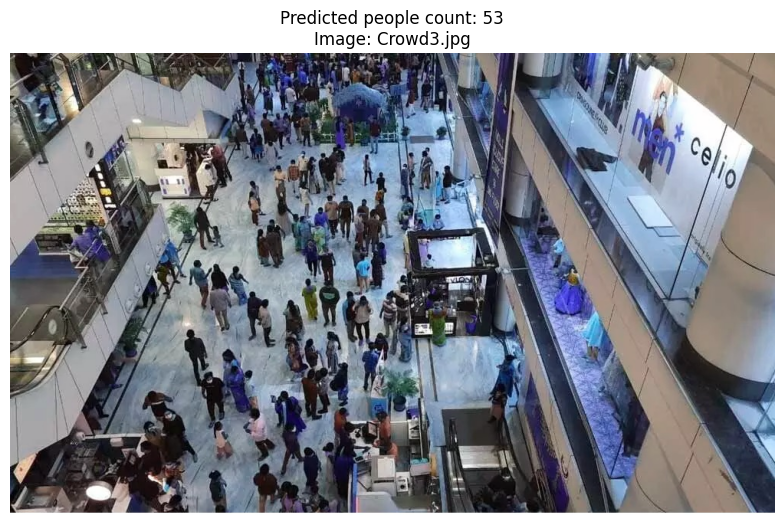

In [44]:
fig = plt.figure(figsize=(10, 6))
img_name3=img_path3.split("/")[-1]
img3 = cv2.imread(img_path3)
img3 = img3.astype(np.uint8)
plt.imshow(img3)
plt.title(f"Predicted people count: {predicted_count3}\nImage: {img_name3}")
plt.axis("off")
plt.show()



Enter the image path to predict:
Image filepath: /kaggle/input/sample1/inp3.jpg
Image resized to (240, 320):


<tf.Tensor: shape=(240, 320, 3), dtype=float32, numpy=
array([[[252.     , 253.     , 248.     ],
        [252.     , 252.     , 252.     ],
        [251.     , 251.     , 251.     ],
        ...,
        [249.     , 249.     , 249.     ],
        [249.     , 249.     , 249.     ],
        [249.     , 249.     , 251.     ]],

       [[252.     , 252.2375 , 249.525  ],
        [252.     , 252.     , 250.475  ],
        [252.     , 252.     , 252.     ],
        ...,
        [248.     , 248.     , 248.     ],
        [248.     , 248.     , 248.     ],
        [248.     , 248.     , 250.     ]],

       [[253.     , 253.     , 251.     ],
        [252.     , 252.     , 250.     ],
        [252.     , 252.     , 250.     ],
        ...,
        [248.     , 248.     , 248.     ],
        [248.     , 248.     , 248.     ],
        [248.     , 248.     , 250.     ]],

       ...,

       [[217.     , 218.     , 213.     ],
        [218.60419, 219.60419, 214.60419],
        [214.37488, 215.374


Tensorflow vector of singular Test image:


<tf.Tensor: shape=(1, 240, 320, 3), dtype=float32, numpy=
array([[[[0.9882353 , 0.99215686, 0.972549  ],
         [0.9882353 , 0.9882353 , 0.9882353 ],
         [0.9843137 , 0.9843137 , 0.9843137 ],
         ...,
         [0.9764706 , 0.9764706 , 0.9764706 ],
         [0.9764706 , 0.9764706 , 0.9764706 ],
         [0.9764706 , 0.9764706 , 0.9843137 ]],

        [[0.9882353 , 0.9891667 , 0.9785294 ],
         [0.9882353 , 0.9882353 , 0.9822549 ],
         [0.9882353 , 0.9882353 , 0.9882353 ],
         ...,
         [0.972549  , 0.972549  , 0.972549  ],
         [0.972549  , 0.972549  , 0.972549  ],
         [0.972549  , 0.972549  , 0.98039216]],

        [[0.99215686, 0.99215686, 0.9843137 ],
         [0.9882353 , 0.9882353 , 0.98039216],
         [0.9882353 , 0.9882353 , 0.98039216],
         ...,
         [0.972549  , 0.972549  , 0.972549  ],
         [0.972549  , 0.972549  , 0.972549  ],
         [0.972549  , 0.972549  , 0.98039216]],

        ...,

        [[0.8509804 , 0.85490197, 

Final prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
39


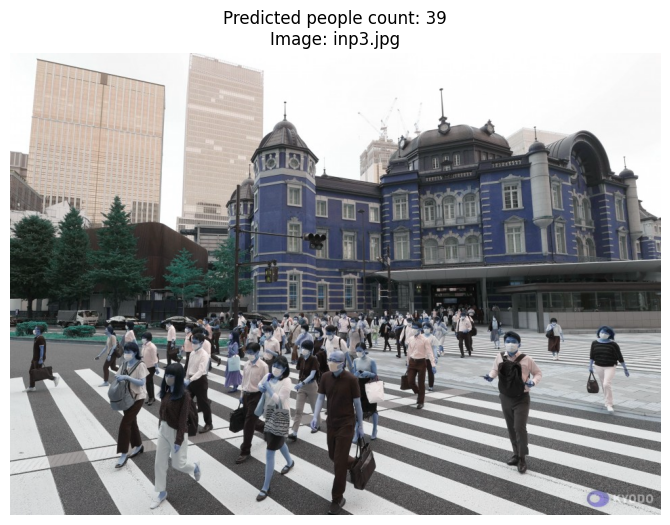

In [45]:
from tensorflow.keras.preprocessing import image
print("Enter the image path to predict:")
img_path4="/kaggle/input/sample1/inp3.jpg"
print(f"Image filepath: {img_path4}")
image_data4 = tf.io.read_file(img_path4)
image_decoded4 = tf.image.decode_jpeg(image_data4)
image_resized4 = tf.image.resize(image_decoded4,img_size)
print(f"Image resized to {img_size}:")
display(image_resized4)
print()
image_normalized4 = tf.cast(image_resized4, dtype=tf.float32) / 255.0
image_batch4 = tf.expand_dims(image_normalized4, axis=0)
print("Tensorflow vector of singular Test image:")
display(image_batch4)
print("Final prediction:")
prediction4 = model1.predict(image_batch4)[0,0]
predicted_count4=int(np.round(prediction4))
print(predicted_count4)
fig = plt.figure(figsize=(10, 6))
img_name4=img_path4.split("/")[-1]
img4 = cv2.imread(img_path4)
img4 = img4.astype(np.uint8)
plt.imshow(img4)
plt.title(f"Predicted people count: {predicted_count4}\nImage: {img_name4}")
plt.axis("off")
plt.show()



In [46]:
!pip install gradio


In [47]:
import gradio as gr
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Set image size (OpenCV expects width, height)
img_size = (320, 240)

# Load model
model = load_model("Crowd_Counting_Model1.h5")

def predict_and_display(img):
    # Resize image to match model input shape
    img_resized = cv2.resize(img, img_size)
    img_normalized = img_resized / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)  # Shape: (1, 240, 320, 3)

    # Predict crowd count
    prediction = model.predict(img_input)
    predicted_count = float(prediction[0][0])

    # Classify risk zone
    if predicted_count < 20:
        risk_zone = "Low Risk 🟢"
    elif predicted_count < 50:
        risk_zone = "Moderate Risk 🟡"
    else:
        risk_zone = "High Risk 🔴"

    # Overlay prediction and risk zone on image
    display_img = img.copy()
    cv2.putText(
        display_img,
        f"Count: {predicted_count:.0f}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )
    # cv2.putText(
    #     display_img,
    #     f"Zone: {risk_zone}",
    #     (10, 65),
    #     cv2.FONT_HERSHEY_SIMPLEX,
    #     0.8,
    #     (0, 255, 0),
    #     2,
    #     cv2.LINE_AA,
    # )

    # Return image and results
    return display_img, f"{predicted_count:.0f}", risk_zone

# Build Gradio interface
interface = gr.Interface(
    fn=predict_and_display,
    inputs=gr.Image(type="numpy", label="Upload Crowd Image"),
    outputs=[
        gr.Image(type="numpy", label="Image with Overlays"),
        gr.Textbox(label="Predicted Crowd Count"),
        gr.Textbox(label="Risk Zone Category")
    ],
    title="Crowd Counting and Risk Zone Detection",
    description="Upload an image to see predicted crowd count and zone classification."
)

# Launch the app
interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://e3d02503c69d5342f6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
